In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = { i:s for s,i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words: # using the first five words to show how it works
    #print(w)
    # padded context of zero tokens with block size expected
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] #crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [5]:
# Build embedding lookup table C

C = torch.randn((27, 2))

In [6]:
# Let's embed a single integer like 5
C[5]

tensor([0.7540, 0.3781])

In [7]:
# One-hot encoding
F.one_hot(torch.tensor(5), num_classes=27).float() @ C
# This is identical to C[5] because of the way matrix multiplication works - one-hot vector has only 1 column with '1'
# So, the C[index] layer can be thought of as a first layer - with no tanh activation.


tensor([0.7540, 0.3781])

In [8]:
#Index capabilities
C[[5,6,7]]

tensor([[ 0.7540,  0.3781],
        [-2.0727,  0.4531],
        [-0.8726,  0.2251]])

In [9]:
C[torch.tensor([5,6,7,7,7])]

tensor([[ 0.7540,  0.3781],
        [-2.0727,  0.4531],
        [-0.8726,  0.2251],
        [-0.8726,  0.2251],
        [-0.8726,  0.2251]])

In [10]:
C[X].shape

torch.Size([228146, 3, 2])

In [11]:
X[13,2]

tensor(1)

In [12]:
C[X][13,2]

tensor([2.0099, 0.0649])

In [13]:
C[1]

tensor([2.0099, 0.0649])

In [14]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [15]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [16]:
# We want to emb @ W1 + b1 but these emb are stacked up
# we have 32 x 3 x 2 that needs to be multiplied by 6 X 100
# Many ways to do this in torch

torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([228146, 6])

In [17]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

In [18]:
a = torch.arange(32)

In [19]:
a.shape

torch.Size([32])

In [20]:
a.view(8,4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31]])

In [21]:
a.view(4,4,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11],
         [12, 13],
         [14, 15]],

        [[16, 17],
         [18, 19],
         [20, 21],
         [22, 23]],

        [[24, 25],
         [26, 27],
         [28, 29],
         [30, 31]]])

In [22]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 32]

In [23]:
# storage offsets, strides and shapes are manipulated -- layout. stride, offset, strided representation
emb.view(-1,6).shape

torch.Size([228146, 6])

emb.view

In [24]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1) == emb.view(-1,6)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [26]:
# -1 infers Pytorch must infer the rest of the dimensions and keep the last one as 6.
# emb.view(-1,6) == emb.view(32,6)

In [27]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [28]:
h.shape

torch.Size([228146, 100])

In [29]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)


In [30]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [31]:
counts = logits.exp()

In [32]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [35]:
# Reorganize and make it concise
b = 3 # block size
d = 2 # dimensional space to encode
e = len(itos) # number of encoded inputs
depth = 100 #number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((e, d), generator=g)
W1 = torch.randn((b*d, depth), generator=g)
b1 = torch.randn(depth, generator=g)
W2 = torch.randn((depth, e), generator=g)
b2 = torch.randn(e, generator=g)
parameters = [C, W1, b1, W2, b2]


In [36]:
sum(p.nelement() for p in parameters)

3481

In [37]:
emb = C[X]
h = torch.tanh(emb.view(-1, b*d) @ W1 + b1) # b*d will allow us to change the dimensional space in lookup table C and change block size as well dynamically
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(19.5052)

In [38]:
# Why we should use cross_entropy instead of manual method above?
# - Pytorch will not create new tensors and create a cluster of operations and fused kernels to implement the operations efficiently
# - backward pass is simpler to implement
# Numerically well behaved - handles logits with large positive numbers ==> exp(large) results in NaN. Cross-entropy deals with it by finding max and 
# subtracting it element-wise leading to negative large number and 0 for max ==> exp() in this case work as expected exp(0) = 1, exp(-100) is e-44 number
F.cross_entropy(logits, Y)

tensor(19.5052)

In [39]:
for p in parameters:
    p.requires_grad = True

In [40]:
# We have low loss quickly because we are overfitting - a single batch with 32 inputs is modeled using 3481 parameters
# leads to overfitting but not zero - it is not zero because "..." index is required to predict different output label

# It also take a lot longer because now that the whole dataset is used for training, every pass goes through every single
# input and adjust grads. Let's construct a minibatch

for _ in range(1000):
    
    #minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, b*d) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    for p in parameters:
        p.data += -0.1 * p.grad
    
    
print(loss.item())


2.5451431274414062


In [41]:
ix = torch.randint(0, X.shape[0], (32,))
ix.shape

torch.Size([32])

In [42]:
# Because we are doing a small minibatch, the quality of the gradient is not good enough, it is approximate but better that way that doing all at once
emb = C[X]
h = torch.tanh(emb.view(-1, b*d) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.6981, grad_fn=<NllLossBackward0>)

In [43]:
# Reorganize and make it concise
b = 3 # block size
d = 2 # dimensional space to encode
e = len(itos) # number of encoded inputs
depth = 100 #number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((e, d), generator=g)
W1 = torch.randn((b*d, depth), generator=g)
b1 = torch.randn(depth, generator=g)
W2 = torch.randn((depth, e), generator=g)
b2 = torch.randn(e, generator=g)
parameters = [C, W1, b1, W2, b2]


In [44]:
lre = torch.linspace(-3,1, 1000)
lrs = 10**lre

In [45]:
# We have low loss quickly because we are overfitting - a single batch with 32 inputs is modeled using 3481 parameters
# leads to overfitting but not zero - it is not zero because "..." index is required to predict different output label

# It also take a lot longer because now that the whole dataset is used for training, every pass goes through every single
# input and adjust grads. Let's construct a minibatch
for p in parameters:
    p.requires_grad = True
    
lri, lossi = [], []
for i in range(10000):
    
    #minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, b*d) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.01 # lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    lri.append(lr)
    lossi.append(loss.item())
    
    
print(loss.item())


2.609196662902832


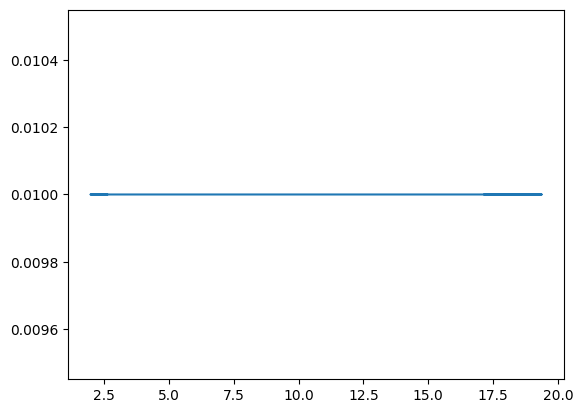

In [46]:
plt.plot(lossi, lri)

2.5329349040985107


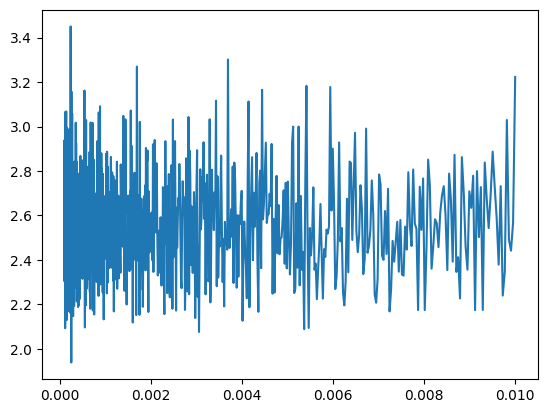

In [47]:
lre = torch.linspace(-2, -4, 1000)
lrs = 10**lre

# We have low loss quickly because we are overfitting - a single batch with 32 inputs is modeled using 3481 parameters
# leads to overfitting but not zero - it is not zero because "..." index is required to predict different output label

# It also take a lot longer because now that the whole dataset is used for training, every pass goes through every single
# input and adjust grads. Let's construct a minibatch
for p in parameters:
    p.requires_grad = True
    
lri, lossi = [], []
for i in range(1000):
    
    #minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, b*d) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    lri.append(lr)
    lossi.append(loss.item())
    
    
print(loss.item())
plt.plot(lri, lossi)

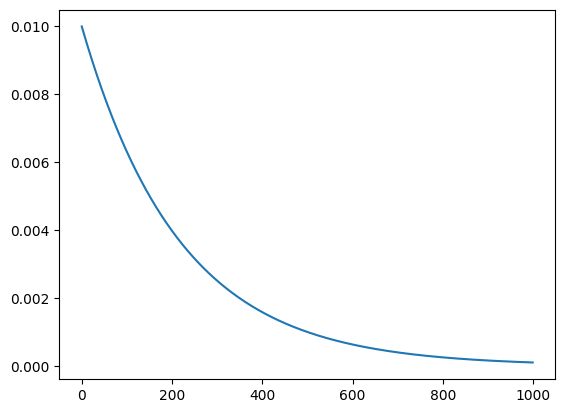

In [48]:
plt.plot(lrs)

In [50]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        # padded context of zero tokens with block size expected
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(137)
random.shuffle(words)
n1 = int (0.8 * len(words))
n2 = int (0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182537, 3]) torch.Size([182537])
torch.Size([22870, 3]) torch.Size([22870])
torch.Size([22739, 3]) torch.Size([22739])


In [51]:
# Reorganize and make it concise
b = 3 # block size
d = 10 # dimensional space to encode
e = len(itos) # number of encoded inputs
depth = 200 #number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((e, d), generator=g)
W1 = torch.randn((b*d, depth), generator=g)
b1 = torch.randn(depth, generator=g)
W2 = torch.randn((depth, e), generator=g)
b2 = torch.randn(e, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

11897

2.0161004066467285


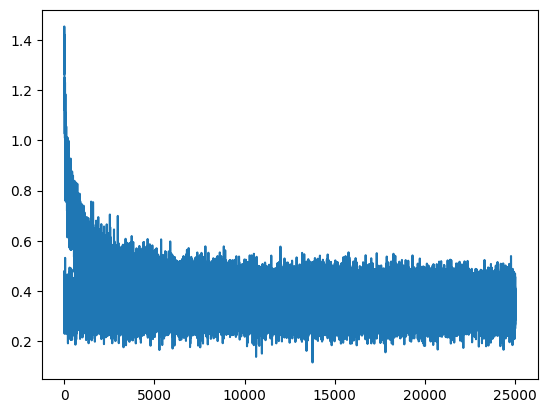

In [52]:
lossi = []
stepi = []
lrdecay = [ 0.1, 0.05, 0.01, 0.005 ]
for lr in lrdecay:
    for i in range(25000):

        #minibatch
        ix = torch.randint(0, Xtr.shape[0], (32,))

        # forward pass
        emb = C[Xtr[ix]]
        h = torch.tanh(emb.view(-1, b*d) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])

        #backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        #update
        for p in parameters:
            p.data += -lr * p.grad

        stepi.append(i)
        lossi.append(loss.log10().item())
    
print(loss.item())
plt.plot(stepi, lossi)


In [53]:
# Using the dev dataset, validate
emb = C[Xdev]
h = torch.tanh(emb.view(-1, b*d) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2099, grad_fn=<NllLossBackward0>)

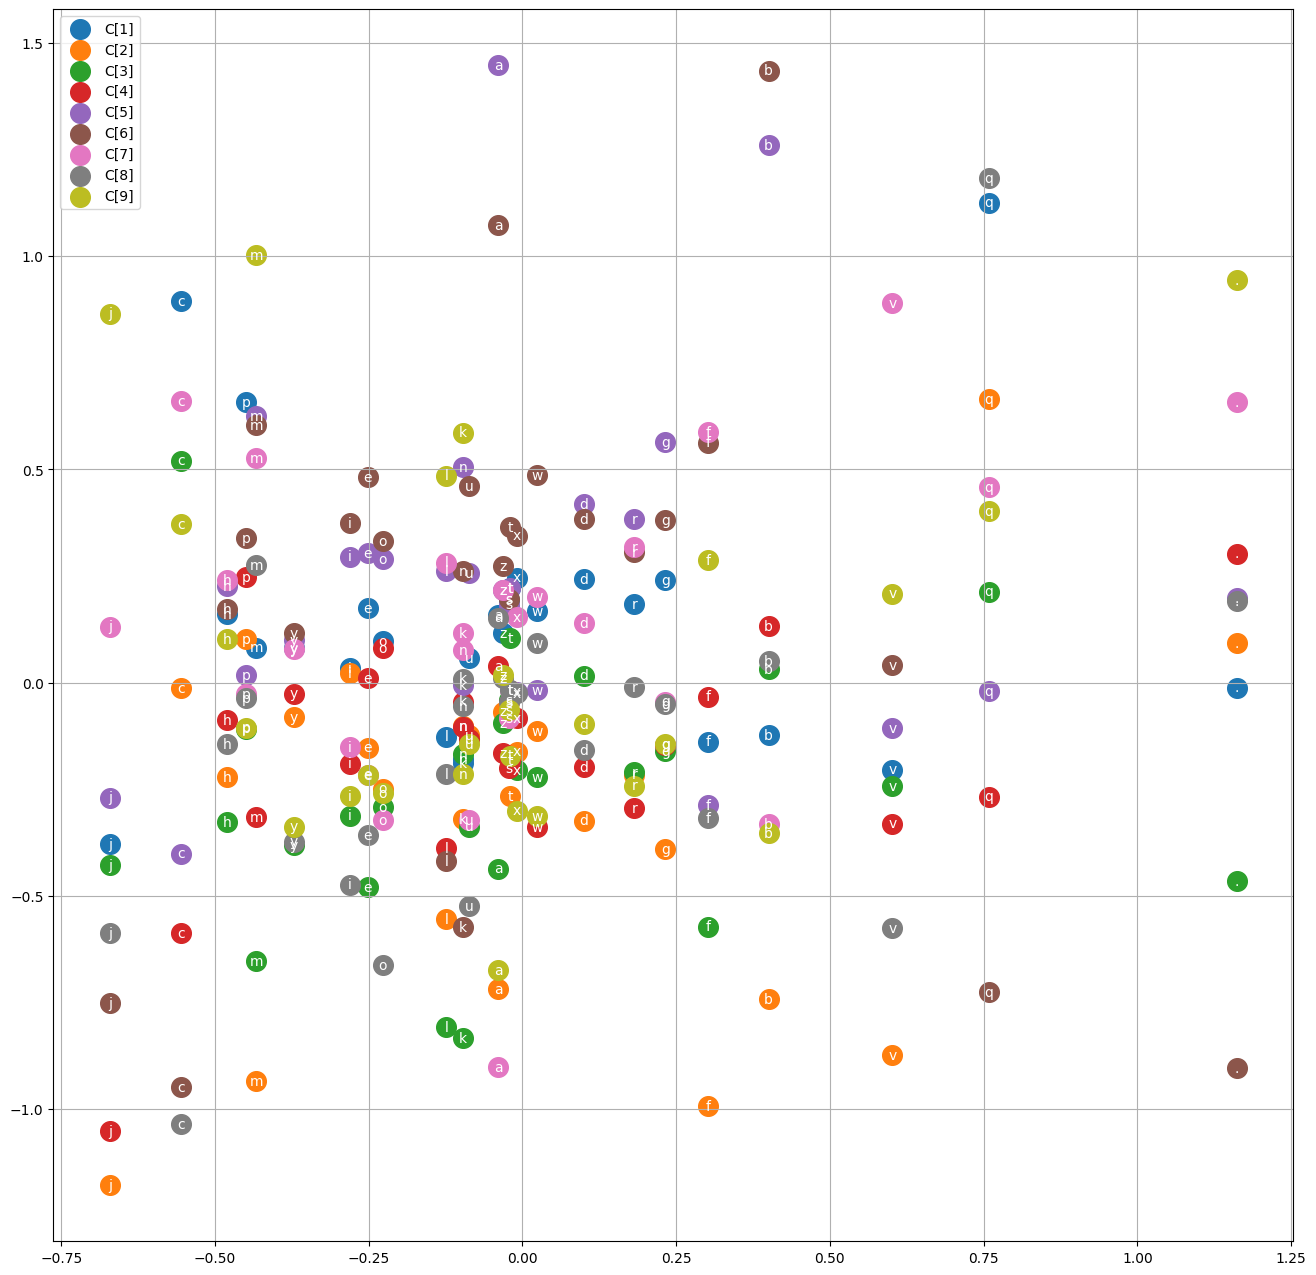

In [69]:
# visualize embedding vectors
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(111)
for i in range(1, C.shape[1]):
    ax1.scatter(C[:,0].data, C[:,i].data, s=200, label=f'C[{i}]')
    for j in range(C.shape[0]):
        plt.text(C[j,0].item(), C[j,i].item(), itos[j], ha="center", va="center", color='white')
plt.grid('minor')
plt.legend(loc='upper left')
plt.show()

In [55]:
C.shape

torch.Size([27, 10])

In [56]:
# Sameple from the model

g = torch.Generator().manual_seed(2147483647 + 137)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

dalice.
ryng.
chaina.
negtumimanso.
maci.
sadalif.
kasi.
azedreye.
sareyam.
ait.
pand.
kanton.
marlis.
kaya.
otre.
ayvanna.
olline.
breanno.
halir.
rarystice.
